# EDA

Criando arquivo com principais dependências e instalando.

In [33]:
%%writefile requirements.txt

pandas==1.5.3
numpy==1.26.1
boto3==1.33.4
pyarrow==13.0.0
fastparquet==2023.10.1

Overwriting requirements.txt


In [34]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [35]:
import requests
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import warnings
import boto3
warnings.filterwarnings("ignore", 'This pattern has match groups')

Definindo variável flag que busca dados de fontes diferentes (AWS S3 ou [Group Lens](https://grouplens.org/)):

In [36]:
ENV_AWS = False

### Buscando dataset do AWS S3 ou Group Lens

In [37]:
def download():
    filename = "ml-25m.zip"
    url = f"https://files.grouplens.org/datasets/movielens/{filename}"
    query_parameters = {"downloadformat": "zip"}
    
    if not os.path.exists(f'{filename}'):
        response = requests.get(url, params=query_parameters)
        with open(filename, mode="wb") as file:
            file.write(response.content)

        with zipfile.ZipFile(filename,"r") as zip_ref:
            zip_ref.extractall()

def to_parquet():
    folder = "ml-25m"
    pd.read_csv(f"{folder}/movies.csv").to_parquet("movies.parquet")
    pd.read_csv(f"{folder}/ratings.csv").to_parquet("ratings.parquet")
    pd.read_csv(f"{folder}/tags.csv").to_parquet("tags.parquet")

In [38]:
if not ENV_AWS:
    download()
    to_parquet()

In [39]:
if ENV_AWS:
    s3 = boto3.client("s3")

    s3.download_file(
        Bucket="cdd-rawdata",
        Key="movies.parquet",
        Filename="movies.parquet",
    )
    
    s3.download_file(
        Bucket="cdd-rawdata",
        Key="ratings.parquet",
        Filename="ratings.parquet",
    )
    
    s3.download_file(
        Bucket="cdd-rawdata",
        Key="tags.parquet",
        Filename="tags.parquet",
    )

# Análise de Dados e Insights

## Movies
| Coluna | Tipo | Descrição |
| --- | --- | --- |
| movieId | int64 | ID único do Filme |
| title | object | Título e ano de lançamento do filme |
| genres | object | Generos do filme separados por "\|" |

In [40]:
df_movies = pd.read_parquet("movies.parquet")
df_movies.shape

(62423, 3)

In [41]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [42]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [43]:
df_movies.genres.nunique()

1639

### Splitando generos e criando novas colunas

In [44]:
def split_genres(df_movies):
    aux = df_movies['genres'].str.count('\|').reset_index(drop=True)
    max_genres = aux.sort_values(ascending=False).reset_index(drop=True)[0]

    columns = []
    for i in range(max_genres+1):
        columns.append(f'genre_{i+1}')

    df_movies[columns] = df_movies['genres'].str.split('|', expand=True)
    return df_movies

In [45]:
df_movies = split_genres(df_movies)
df_movies.head(2)

,movieId,title,genres,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure,Children,Fantasy,None,None,None,None,None,None,None


#### Criando coluna de Total de Generos

In [46]:
df_movies['total_genres'] = df_movies['genres'].str.count('\|') + 1
df_movies.head(2)

,movieId,title,genres,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,total_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None,5
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure,Children,Fantasy,None,None,None,None,None,None,None,3


### Total de Generos por Filme

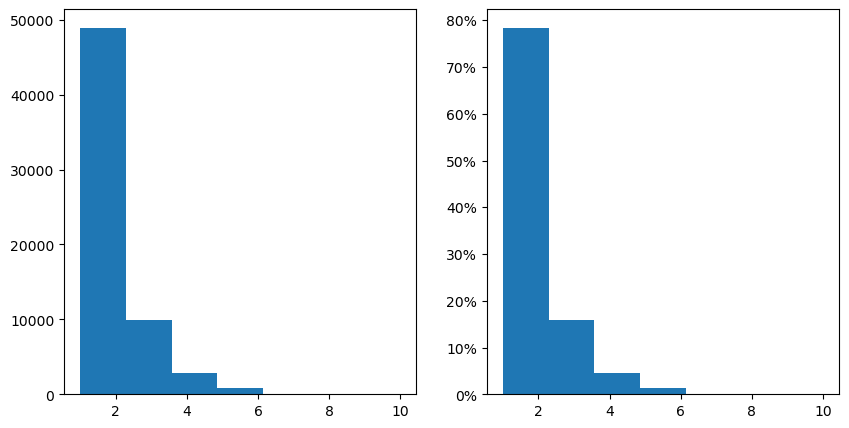

In [47]:
fig = plt.figure(figsize=(10,5))

#hist 1
fig.add_subplot(1,2,1)
plt.hist(df_movies['total_genres'], bins=7)

#hist 2
fig.add_subplot(1,2,2)
plt.hist(df_movies['total_genres'], weights=np.ones(len(df_movies['total_genres'])) / len(df_movies['total_genres']), bins=7)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))



plt.show()

### Contagem de frequência de genero por filme

In [48]:
#Criando lista com todos os gêneros distintos
genres = df_movies.T.values.tolist()[3:12][0]
genres = list(dict.fromkeys(genres))
print(genres)

['Adventure', 'Comedy', 'Action', 'Drama', 'Crime', 'Children', 'Mystery', 'Documentary', 'Animation', 'Thriller', 'Horror', 'Fantasy', 'Western', 'Film-Noir', 'Romance', 'War', 'Sci-Fi', 'Musical', 'IMAX', '(no genres listed)']


In [49]:
#Contando total de filmes por Gênero
df_genres_qtd = pd.DataFrame()
for g in genres:
    if g != None:
        df_aux = pd.DataFrame({'genre': [g],
                               'qtd': df_movies.groupby(['genres'])['genres'].apply(lambda x: x[x.str.contains(g)].count()).sum()})
        if df_genres_qtd.empty:
            df_genres_qtd = df_aux
        else:
            df_genres_qtd = pd.concat([df_genres_qtd, df_aux])
df_genres_qtd.head(3)

/tmp/ipykernel_22151/1036263955.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  'qtd': df_movies.groupby(['genres'])['genres'].apply(lambda x: x[x.str.contains(g)].count()).sum()})


,genre,qtd
0,Adventure,4145
0,Comedy,16870
0,Action,7348


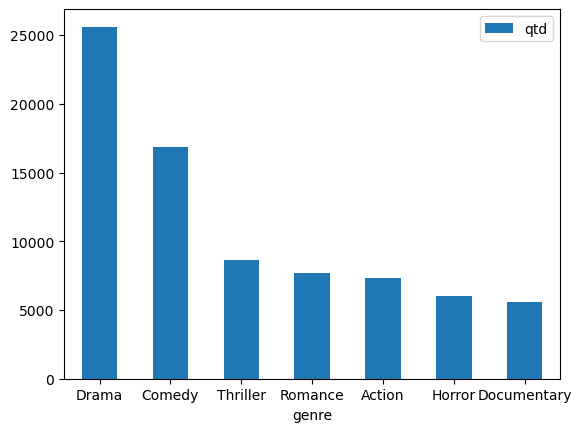

In [50]:
ax = df_genres_qtd.sort_values(by='qtd', ascending=False).head(7).plot.bar(x='genre', y='qtd', rot=0)

## Ratings
| Coluna | Tipo | Descrição |
| :- | -: | :-: |
| userId | int64 | ID único do Usuário |
| movieId | int64 | ID único do Filme |
| rating | float64 | Nota de avaliação do usuário para o filme. As notas variam 0.5 pontos e estão no intervalo: [0.5, 5]. |
| timestamp | int64 | Marca temporal em que o usuário realizou a avaliação |

In [51]:
df_ratings = pd.read_parquet("ratings.parquet")
df_ratings.shape

(25000095, 4)

In [52]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [53]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [54]:
df_ratings.rating.value_counts()

4.0    6639798
3.0    4896928
5.0    3612474
3.5    3177318
4.5    2200539
2.0    1640868
2.5    1262797
1.0     776815
1.5     399490
0.5     393068
Name: rating, dtype: int64

Text(0.5, 1.0, 'Freq Notas de Avaliações')

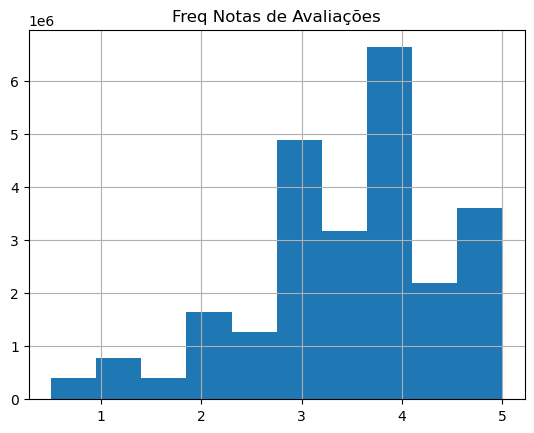

In [55]:
df_ratings.rating.hist()
plt.title('Freq Notas de Avaliações')

In [56]:
df_ratings['userId_ratings'] = df_ratings.groupby(by='userId').userId.transform('count')
df_ratings.head()

,userId,movieId,rating,timestamp,userId_ratings
0,1,296,5.0,1147880044,70
1,1,306,3.5,1147868817,70
2,1,307,5.0,1147868828,70
3,1,665,5.0,1147878820,70
4,1,899,3.5,1147868510,70


Text(0.5, 1.0, 'Quantidade de Avaliações por usuário')

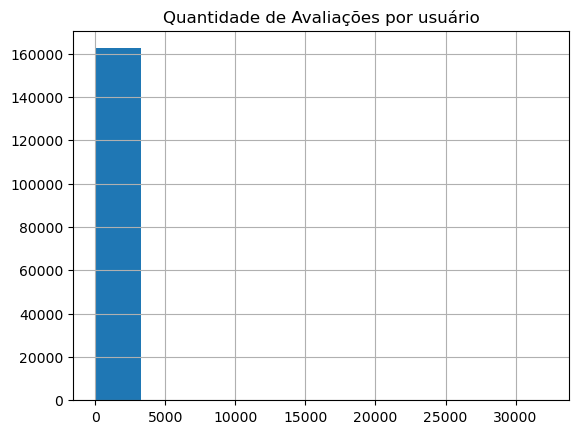

In [57]:
df_ratings.drop_duplicates(subset=['userId']).userId_ratings.hist()
plt.title('Quantidade de Avaliações por usuário')

#### existem alguns usuários com um alto volume de avaliações (exemplo user com 32.2k de avaliações)

In [58]:
aux = df_ratings.drop_duplicates(subset=['userId']).reset_index(drop=True)

In [59]:
aux.userId_ratings.nunique()

2119

In [60]:
aux.userId_ratings.sort_values(ascending=False)

72314     32202
80973      9178
137292     8913
33843      7919
20054      7488
          ...  
64554        20
64416        20
64425        20
50           20
80284        20
Name: userId_ratings, Length: 162541, dtype: int64

In [61]:
df_agg = aux.groupby(by='userId_ratings').userId.nunique().reset_index()
df_agg.sort_values(by='userId', ascending=False).head(100)

,userId_ratings,userId
0,20,4611
1,21,3406
2,22,3112
3,23,2916
5,25,2740
...,...,...
94,114,418
96,116,410
101,121,406
100,120,405


In [62]:
df_agg = aux.groupby(by='userId_ratings').userId.nunique().reset_index()
df_agg.sort_values(by='userId', ascending=True).head(1000)

,userId_ratings,userId
1629,1742,1
1645,1767,1
1646,1768,1
1647,1771,1
1697,1876,1
...,...,...
1089,1112,4
1257,1284,4
1258,1285,4
796,816,4


Text(0.5, 1.0, 'Quantidade de Avaliações por usuário')

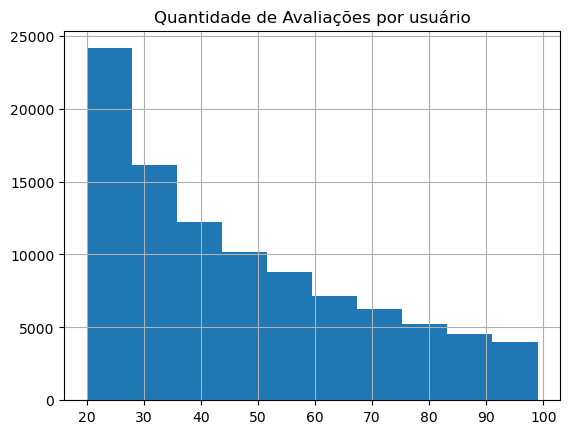

In [63]:
aux = df_ratings.drop_duplicates(subset=['userId'])
aux[aux['userId_ratings']<100].userId_ratings.hist()

plt.title('Quantidade de Avaliações por usuário')

### Outro dado interessante é que na base de avaliações o mínimo de avaliações realizadas por usuário é de 20

In [64]:
df_agg = aux.groupby(by='userId_ratings').userId.nunique().reset_index()
df_agg.sort_values(by='userId_ratings', ascending=True).head(1000)

,userId_ratings,userId
0,20,4611
1,21,3406
2,22,3112
3,23,2916
4,24,2599
...,...,...
995,1017,4
996,1018,7
997,1019,2
998,1020,6


## Tags
| Coluna | Tipo | Descrição |
| :- | -: | :-: |
| userId | int64 | ID único do Usuário |
| movieId | int64 | ID único do Filme |
| tag | object | Nota de avaliação do usuário para o filme. As notas variam 0.5 pontos e estão no intervalo: [0.5, 5]. |
| timestamp | int64 | Marca temporal em que o usuário realizou a avaliação |

In [65]:
df_tags = pd.read_parquet("tags.parquet")
df_tags.shape

(1093360, 4)

In [66]:
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [67]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


In [68]:
df_tags.tag.value_counts()

sci-fi               8330
atmospheric          6516
action               5907
comedy               5702
surreal              5326
                     ... 
Internet gambling       1
family flim             1
Washington State        1
crazy neighbor          1
religious zealots       1
Name: tag, Length: 73050, dtype: int64

In [69]:
df_tags.tag.nunique()

73050